Loaded 5006 games.
Unique players: 40953


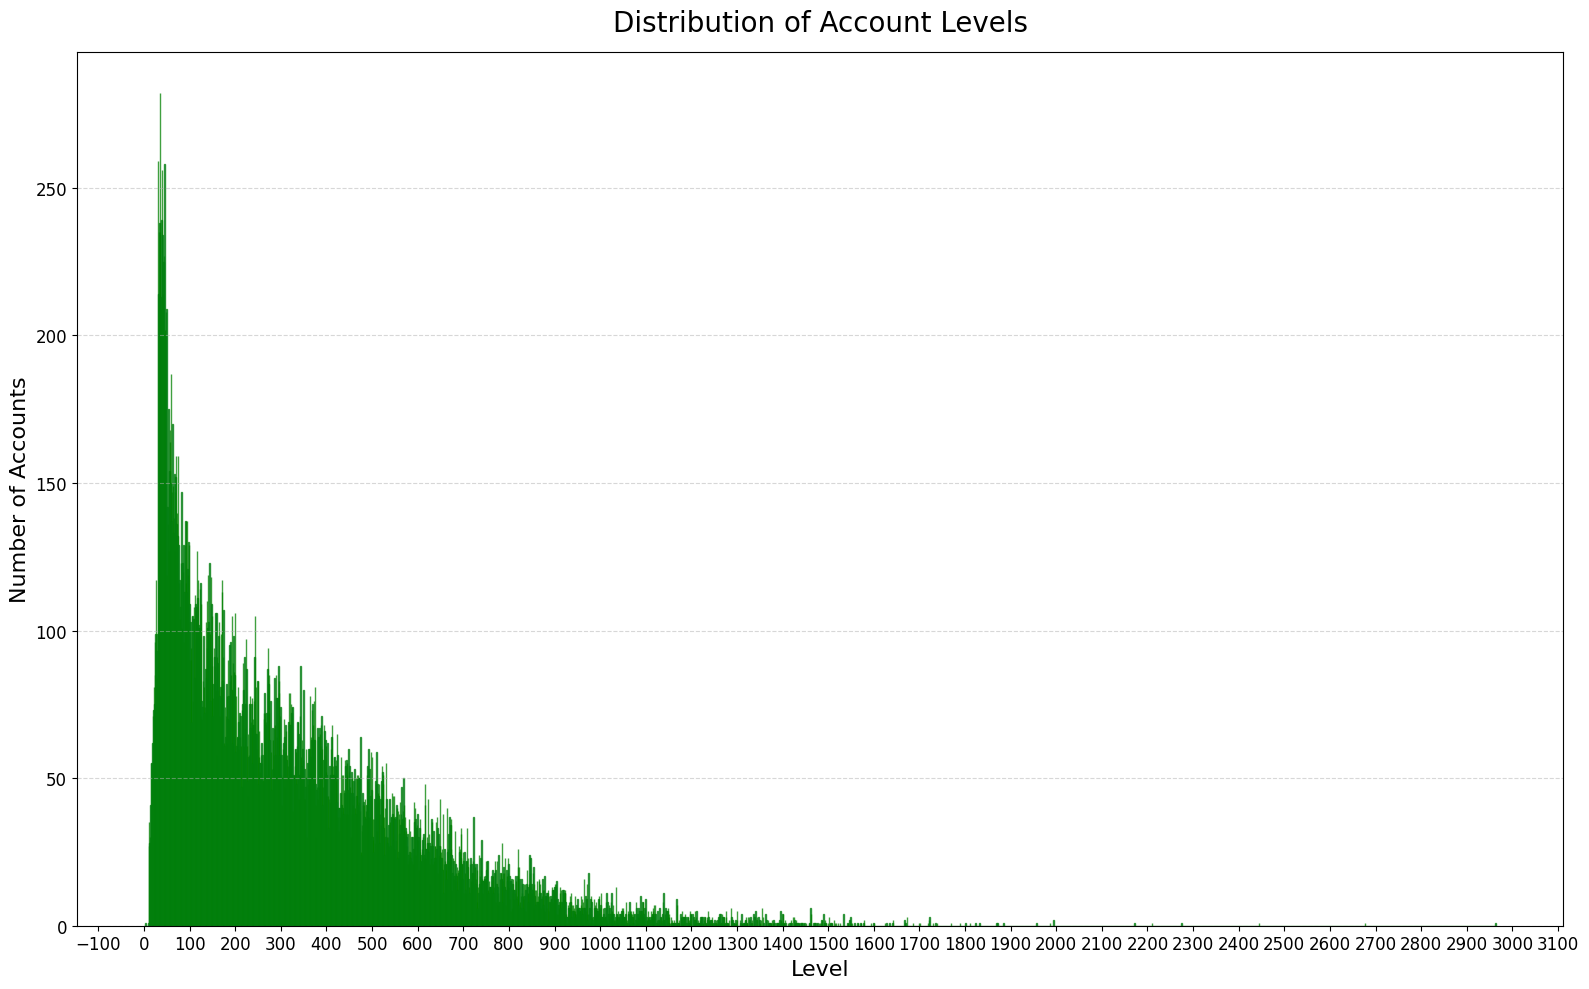

"Qnoxs #17165" Level: 2963
0.5195195195195195


In [57]:
import json
import os
import math

def load_game(filename: str) -> dict:
    """Load game data from a JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data


games = []
game_path = os.path.join(".", "games", "classic")

for file in os.listdir(game_path):
    if file.endswith(".json"):
        game_data = load_game(os.path.join(game_path, file))
        games.append(game_data)

print(f"Loaded {len(games)} games.")

players = []
players_name_lvl = {}
for game in games:
    for participant in game.get("info").get("participants", []):
        players_name_lvl[participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")] = participant.get("summonerLevel", 0)

for name, level in players_name_lvl.items():
    players.append((name, level))

print(f"Unique players: {len(players)}")

def plot_level_distribution(games: list):
    import matplotlib.pyplot as plt

    # Levels einsammeln
    levels = []
    for game in games:
        for participant in game.get("info", {}).get("participants", []):
            levels.append(participant.get("summonerLevel", 0))

    # Figur
    plt.figure(figsize=(16, 10))

    # Histogramm mit schöneren Styles
    plt.hist(
        levels,
        bins=range(1, max(levels) + 2),
        edgecolor="green",        # dünne Linien für klarere Balken
        alpha=0.75,               # etwas Transparenz
        linewidth=1.0
    )
    plt.locator_params(axis="x", nbins=40)
    # Titel und Achsen
    plt.title("Distribution of Account Levels", fontsize=20, pad=15)
    plt.xlabel("Level", fontsize=16)
    plt.ylabel("Number of Accounts", fontsize=16)

    # Schönes Grid
    plt.grid(axis="y", linestyle="--", alpha=0.5)

    # Ticks lesbarer machen
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Layout optimieren
    plt.tight_layout()

    plt.show()

        

def get_team_levels(game: dict) -> tuple:
    team1_levels = []
    team2_levels = []
    for participant in game.get("info").get("participants", []):
        if participant.get("teamId") == 100:
            team1_levels.append(participant.get("summonerLevel", 0))
        else:
            team2_levels.append(participant.get("summonerLevel", 0))
    return sum(team1_levels) / len(team1_levels), sum(team2_levels) / len(team2_levels)

def get_team_min_max_level(game: dict) -> tuple:
    team1_max_level = 0
    team1_min_level = math.inf
    team2_max_level = 0
    team2_min_level = math.inf

    for p in game.get("info").get("participants", []):
        if p.get("teamId") == 100:
            if p.get("summonerLevel", 0) > team1_max_level:
                team1_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team1_min_level:
                team1_min_level = p.get("summonerLevel", 0)
        if p.get("teamId") == 200:
            if p.get("summonerLevel", 0) > team2_max_level:
                team2_max_level = p.get("summonerLevel", 0)
            if p.get("summonerLevel", 0) < team2_min_level:
                team2_min_level = p.get("summonerLevel", 0)
    return ((team1_min_level, team1_max_level), (team2_min_level, team2_max_level))

def higher_absolute_level_winrate(games:list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_max_level = 0
    won_with_lower_max_level = 0

    for game in games:
        l = get_team_min_max_level(game)
        team1_min_level, team1_max_level = l[0]
        team2_min_level, team2_max_level = l[1]
        team1_win = False
        team2_win = False

        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True

        if team1_max_level > team2_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_higher_max_level += 1
            if team2_win:
                won_with_lower_max_level += 1

        if team2_max_level > team1_max_level and abs(team1_max_level - team2_max_level) > difference:
            all_games += 1
            if team1_win:
                won_with_lower_max_level += 1
            if team2_win:
                won_with_higher_max_level += 1
    return won_with_higher_max_level/all_games

def higher_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_higher_level/all_games
    else:
        return 0
    
def lower_level_winrate(games: list, difference: float = 0.0) -> float:
    all_games = 0
    won_with_higher_level = 0
    won_with_lower_level = 0
    for game in games:
        team1_level, team2_level = get_team_levels(game)
        team1_win = False
        team2_win = False
        for participant in game.get("info").get("participants", []):
            if participant["teamId"] == 100 and participant["win"]:
                team1_win = True
            elif participant["teamId"] == 200 and participant["win"]:
                team2_win = True
        if team1_win == team2_win:
            print("Error! It is impossible that both teams win")
            exit(-1)
        if team1_level > team2_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team1_win:
                won_with_higher_level += 1
            if team2_win:
                won_with_lower_level += 1
        
        if team2_level > team1_level and (abs(team1_level - team2_level) > difference):
            all_games += 1
            if team2_win:
                won_with_higher_level += 1
            if team1_win:
                won_with_lower_level += 1
    #print(f"{won_with_higher_level} Wins with higher level and {won_with_lower_level} Wins with lower level of {all_games} games")
    if all_games > 0:
        return won_with_lower_level/all_games
    else:
        return 0

def get_highest_level_player(games: list) -> tuple:
    highest_level = -1
    player_name = ""
    for game in games:
        for participant in game.get("info").get("participants", []):
            level = participant.get("summonerLevel", 0)
            if level > highest_level:
                highest_level = level
                player_name = participant.get("riotIdGameName") + " #" + participant.get("riotIdTagline")
    return player_name, highest_level

plot_level_distribution(games)
hname, hlevel = get_highest_level_player(games)
print(f"\"{hname}\" Level: {hlevel}")

print(higher_level_winrate(games, 200))


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600]


[0.5109912070343725, 0.5111158162185052, 0.5117266026356936, 0.5109296180638963, 0.5086273499871233, 0.5099009900990099, 0.5120356612184249, 0.51232, 0.5169198895027625, 0.5112107623318386, 0.5119384864427358, 0.5070422535211268, 0.5074770863482875, 0.5060115002613695, 0.505125284738041, 0.5050188205771644, 0.5047879616963065, 0.5015174506828528, 0.5075125208681135, 0.5096241979835013, 0.5195195195195195, 0.5208791208791209, 0.5214285714285715, 0.5104438642297651, 0.5143266475644699, 0.5129032258064516, 0.5161870503597122, 0.5233463035019456, 0.5331858407079646, 0.5341463414634147, 0.5437158469945356, 0.5435435435435435, 0.5514950166112956, 0.5571955719557196, 0.56, 0.5482456140350878, 0.5362318840579711, 0.5243243243243243, 0.5454545454545454, 0.5259259259259259, 0.4957983193277311, 0.5196078431372549, 0.53125, 0.5581395348837209, 0.5657894736842105, 0.546875, 0.5409836065573771, 0.5192307692307693, 0.5555555555555556, 0.5641025641025641, 0.5428571428571428, 0.59375, 0.566666666666666

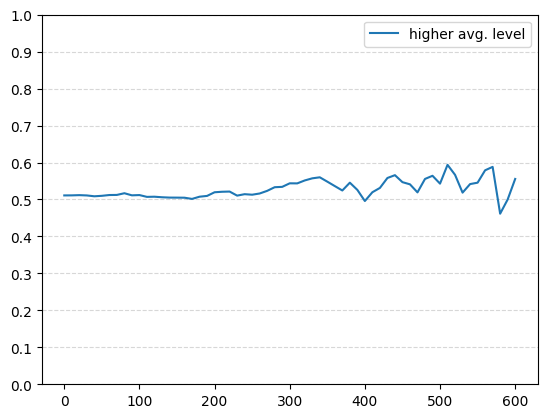

In [58]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 61)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_level_winrate(games, d)
    winrates_higher.append(wr)
    winrates_lower.append(lower_level_winrate(games, d))
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher avg. level")
#plt.plot(diffs, winrates_lower, label="lower avg. level")
plt.legend()
plt.show()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]
[0.5124, 0.5119489081170169, 0.5137420718816068, 0.5153427638737759, 0.5171563130746805, 0.5175519630484988, 0.5178401522359658, 0.5181818181818182, 0.5180753564154786, 0.5168687401159726, 0.5152838427947598, 0.5175808720112518, 0.5163170163170163, 0.5158466646543918, 0.51714463840399, 0.5182907089673033, 0.5166163141993958, 0.5172533983966539, 0.5195227765726681, 0.5202550637659414, 0.5212807497071457, 0.5209508460918614, 0.5201850294365012, 0.5193151887620719, 0.5147392290249433, 0.512541410317084

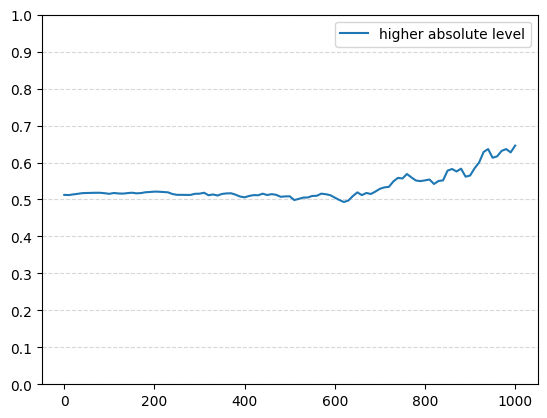

In [60]:
import matplotlib.pyplot as plt

diffs = [i * 10 for i in range(0, 101)]
winrates_higher = []
winrates_lower = []
print(diffs)
for d in diffs:
    wr = higher_absolute_level_winrate(games, d)
    winrates_higher.append(wr)
print(winrates_higher)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.yticks([i/10 for i in range(0, 11)])
plt.plot(diffs, winrates_higher, label="higher absolute level")
plt.legend()
plt.show()